In [22]:
import spacy
from spacy_layout import spaCyLayout
from pipeline_merge_pdf import process_pdf_folder
import os
import time

#Ordner, in dem PDFs liegen
pdf_folder = "../data/DSA/Der_blaue_Bruder"
#pdf_folder = "../data/DSA/Adel_Recht_und_Edelmut"
merged_pdf_path = os.path.join(pdf_folder, "_combined.pdf")

#Prüfen ob eine merged-Datei bereits vorhanden ist. Falls nicht, diese erzeugen
if os.path.exists(merged_pdf_path):
    print("Die Datei _combined.pdf existiert bereits unter folgendem Pfad:",merged_pdf_path)
    print("Lade die Datei lokal..\n")
    time.sleep(0.5)
    nlp = spacy.blank("de")
    layout = spaCyLayout(nlp)
    doc = layout(merged_pdf_path)
else:
    print("Die Datei _combined.pdf existiert noch nicht. Merge-Pipeline wird durchgeführt..")
    time.sleep(0.5)
    #Pipeline ausführen
    doc = process_pdf_folder(pdf_folder)

#spaCy-Doc
print("\nAnzahl Layout-Spans:", len(doc.spans["layout"]))


Die Datei _combined.pdf existiert bereits unter folgendem Pfad: ../data/DSA/Der_blaue_Bruder/_combined.pdf
Lade die Datei lokal..



2025-12-10 20:34:56,558 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-12-10 20:34:56,586 - INFO - Going to convert document batch...
2025-12-10 20:34:56,587 - INFO - Initializing pipeline for StandardPdfPipeline with options hash f9730ffaa6e7f8d4fb0c98c8df3f18cb
2025-12-10 20:34:56,589 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2025-12-10 20:34:56,590 - INFO - easyocr cannot be used because it is not installed.
2025-12-10 20:34:56,591 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-12-10 20:34:56,601 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-12-10 20:34:56,606 [RapidOCR] download_file.py:60: File exists and is valid: /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-12-10 20:34:56,607 [RapidOCR] torch.py:54: Using /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO


Anzahl Layout-Spans: 1833


In [23]:
from pipeline_preproc_pdf import process_doc_into_posts 

#Posts extrahieren + bereinigen
posts = process_doc_into_posts(doc)

#Posts ausgeben
for i, p in enumerate(posts):
    print(f"--- Post {i+1} ---\n{p}\n")

["von Shanna Seite 1 von 12 Verfasst: 22.08.2021 18:14 Die Grafschaft Heldentrutz zwischen Finsterkamm und Finsterbach ist eine der ärmsten und wildesten Regionen Weidens. Sie wird von zahlreichen dichten und gefährlichen Wäldern, mit Harpyien, Orks und Drachen, urwüchsigen Wiesen sowie von Heide- und Moorlandschaften geprägt. Neben ein wenig Kornwirtschaft betreiben die Leute vor allem Kohl- und Rübenanbau, sowie Viehwirtschaft, vor allem Schafe und Ziegen. Einzige  Ausnahme  in der ganzen Ärmlichkeit ist die Baronie Nordhag mit der gleichnamigen Stadt, die durch die dort vorhandenen Salzvorkommen zu Reichtum gekommen  ist.  Nordhag bildet das wirtschaftliche und kulturelle Zentrum der Grafschaft, liegt an wichtigen Handelswegen (Norrnstieg, Alter Weg,  Alte Straße), richtet zweimal  im Jahr den großen Wollmarkt aus und ist durch die Feste Norrbrug ganz gut geschützt. Am 10. Efferd des Jahres 1040 BF, zur Zeit des zweiten Wollmarktes leben in Nordhag um  die 900 Einwohner, man  findet

In [24]:
from pipeline_preproc_lemma import TextPreprocessingPipeline #Posts von Satzzeichen und Ziffern bereinigen & anschließend lemmatisieren 

pipeline = TextPreprocessingPipeline()
posts_clean = pipeline.process_posts(posts, debug=False) #debug für print-Ausgaben der Zwischenschritte

#Posts ausgeben
for i, p in enumerate(posts_clean):
    print(f"--- Post {i+1} ---\n{p}\n")

Lade spaCy-Modell ...
--- Post 1 ---
der grafschaft heldentrutz zwischen finsterkamm und finsterbach sein einer der arm und wilde region weidens sie werden von zahlreich dicht und gefährlich wäldern mit harpyi orks und drach urwüchsigen weisen sowie von heide und moorlandschaft prägen neben ein wenig kornwirtschaft betreiben der leute vor alle kohl und rübenanbau sowie viehwirtschaft vor alle schaf und ziegen einzig ausnahme in der ganz ärmlichkeit sein der baronie nordhag mit der gleichnamig stadt der durch der dort vorhanden salzvorkomme zu reichtum kommen sein nordhag bilden der wirtschaftlich und kulturell zentrum der grafschaft liegen an wichtig handelsweg norrnstieg alt weg alt straße richten zweimal in jahr der groß wollmarkt aus und sein durch der fest norrbrug ganz gut schützen an efferd der jahr bf zu zeit der zweiter wollmarkt leben in nordhag um der einwohner man finden dort tempel von rondra phex peraine und ingerimm sowie diverser gasthäuser und tavernen der markt und der

## EXKURS - START

In [25]:
from pipeline_pos_verbs import VerbExtractionPipeline #pos-tagging

pipeline = VerbExtractionPipeline()

verb_only_posts = pipeline.process_posts(posts_clean, debug=False)

#Posts ausgeben
for i, p in enumerate(verb_only_posts):
    print(f"--- Post {i+1} ---\n{p}\n")


Lade spaCy-Modell für Verbextraktion ...
--- Post 1 ---
sein werden wäldern urwüchsigen weisen prägen betreiben sein salzvorkomme kommen sein bilden liegen wollmarkt norrbrug schützen wollmarkt leben finden ziehen haben treiben paktieren aufspürt verfolgen verlor überlegen bleiben schaden können sein abschließen haben schauen brauchen kommen erinnern erreichen sein sollen vorbeischauen machen sein erklären führen eintreffen

--- Post 2 ---
kleiden ledern machen werden sein stehen werden verstehen leben können sein sein gehen lassen geben haben verblichen sein erkennen kehren schauen antrifft werden fragen suchen essen werden lauschen hören suchen

--- Post 3 ---
haben freuen kennen können schaden lenken entspannen reiten rüsten bleiben

--- Post 4 ---
verlieren wirken haben finden kehren haben gewöhnen geben sein halten räuspern verschaffen suchen

--- Post 5 ---
besucht duften wollmarkt sein scheinen angegraut führen verfasst finden aufnimmt scheinen stühlen geben

--- Post 6 ---
erre

## EXKURS - ENDE

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
result = tfidf.fit_transform(posts_clean) #posts_clean

In [34]:
import nltk 
nltk.download('stopwords') #Abfrage einbauen, ob stopwords bereits heruntergeladen wurden
from nltk.corpus import stopwords #Import der Stopwords aus NLTK

german_stopwords = stopwords.words('german') #Stopwords aus NLTK laden

newwords = ["bf", "peraine", "bolgrim", "aleezikiel", "verfasst", "mordred"] #weitere Stopwords ergänzen
german_stopwords.extend(newwords)

print(german_stopwords)

tfidf = TfidfVectorizer(stop_words=german_stopwords, max_df=0.95, min_df=1)
result = tfidf.fit_transform(verb_only_posts) #TF-IDF-Matrix erstellen


['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anderr', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies', 'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euc

[nltk_data] Downloading package stopwords to /home/timc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
import pandas as pd

words = tfidf.get_feature_names_out() #Wortliste aus dem Vokabular der TF-IDF-Matrix
df = pd.DataFrame(result.toarray(), columns=words) #DataFrame aus der TF-IDF-Matrix erstellen
print(df)

     abfüllt  abgeben  abhalten  ablegen  ablehnen  ablenken  abnehmen  \
0        0.0      0.0       0.0      0.0       0.0       0.0       0.0   
1        0.0      0.0       0.0      0.0       0.0       0.0       0.0   
2        0.0      0.0       0.0      0.0       0.0       0.0       0.0   
3        0.0      0.0       0.0      0.0       0.0       0.0       0.0   
4        0.0      0.0       0.0      0.0       0.0       0.0       0.0   
..       ...      ...       ...      ...       ...       ...       ...   
356      0.0      0.0       0.0      0.0       0.0       0.0       0.0   
357      0.0      0.0       0.0      0.0       0.0       0.0       0.0   
358      0.0      0.0       0.0      0.0       0.0       0.0       0.0   
359      0.0      0.0       0.0      0.0       0.0       0.0       0.0   
360      0.0      0.0       0.0      0.0       0.0       0.0       0.0   

     abschließen  absehen  abteilen  ...  überlegen  überlässen  übermannt  \
0       0.166752      0.0       0

In [36]:
#Wichtigste Wörter pro Post ausgeben
for i, doc in enumerate(verb_only_posts):
    print(f"\n--- Wichtigste Wörter in Post {i+1} ---")
    row = df.iloc[i]
    print(row.sort_values(ascending=False).head(7))



--- Wichtigste Wörter in Post 1 ---
wollmarkt    0.350932
kommen       0.202107
aufspürt     0.187747
schützen     0.187747
wäldern      0.187747
norrbrug     0.187747
betreiben    0.187747
Name: 0, dtype: float64

--- Wichtigste Wörter in Post 2 ---
suchen        0.413902
antrifft      0.285460
ledern        0.285460
verblichen    0.285460
kleiden       0.266787
lauschen      0.253538
kehren        0.253538
Name: 1, dtype: float64

--- Wichtigste Wörter in Post 3 ---
lenken        0.395844
rüsten        0.395844
freuen        0.369951
reiten        0.369951
entspannen    0.369951
schaden       0.337329
kennen        0.293064
Name: 2, dtype: float64

--- Wichtigste Wörter in Post 4 ---
räuspern       0.402543
verschaffen    0.376211
gewöhnen       0.357528
kehren         0.357528
verlieren      0.357528
suchen         0.291833
finden         0.263563
Name: 3, dtype: float64

--- Wichtigste Wörter in Post 5 ---
scheinen     0.429048
aufnimmt     0.354013
besucht      0.354013
stühlen  

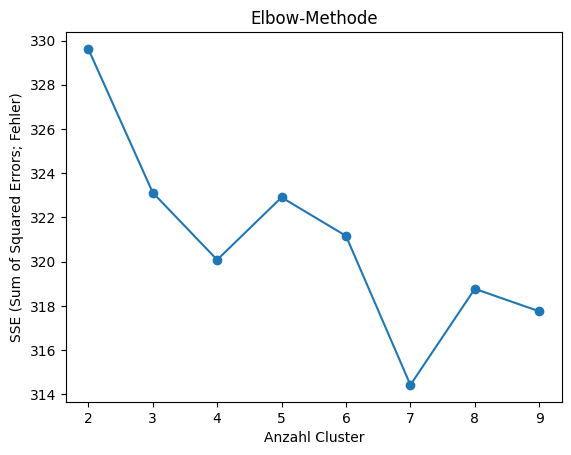

In [37]:
#Wie viele Cluster sind sinnvoll? (Elbow-Methode)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
K = range(2, 10)  # teste 2-9 Cluster

for k in K:
    km = KMeans(n_clusters=k, random_state=42) #Initialisiere KMeans
    km.fit(result) #Fitte KMeans auf die TF-IDF-Matrix
    sse.append(km.inertia_) #SSE (Sum of Squared Errors) speichern

plt.plot(K, sse, '-o') #Elbow-Kurve plotten
plt.xlabel("Anzahl Cluster")
plt.ylabel("SSE (Sum of Squared Errors; Fehler)")
plt.title("Elbow-Methode")
plt.show()

In [38]:
#Clustering mittels k-means
from sklearn.cluster import KMeans

#KMeans Clustering
k = 4  # Anzahl Cluster
model = KMeans(n_clusters=k, random_state=42) #Initialisiere KMeans
model.fit(result) #Fitte KMeans auf die TF-IDF-Matrix

#Cluster-Zuordnung pro Dokument
labels = model.labels_

for i, (doc, label) in enumerate(zip(posts_clean, labels)):
    print(f"[Cluster {label}] {doc}")

[Cluster 0] der grafschaft heldentrutz zwischen finsterkamm und finsterbach sein einer der arm und wilde region weidens sie werden von zahlreich dicht und gefährlich wäldern mit harpyi orks und drach urwüchsigen weisen sowie von heide und moorlandschaft prägen neben ein wenig kornwirtschaft betreiben der leute vor alle kohl und rübenanbau sowie viehwirtschaft vor alle schaf und ziegen einzig ausnahme in der ganz ärmlichkeit sein der baronie nordhag mit der gleichnamig stadt der durch der dort vorhanden salzvorkomme zu reichtum kommen sein nordhag bilden der wirtschaftlich und kulturell zentrum der grafschaft liegen an wichtig handelsweg norrnstieg alt weg alt straße richten zweimal in jahr der groß wollmarkt aus und sein durch der fest norrbrug ganz gut schützen an efferd der jahr bf zu zeit der zweiter wollmarkt leben in nordhag um der einwohner man finden dort tempel von rondra phex peraine und ingerimm sowie diverser gasthäuser und tavernen der markt und der salzhandel ziehen zu die

In [39]:
#Welche Wörter charakterisieren jedes Cluster?
import numpy as np

words = tfidf.get_feature_names_out()
centers = model.cluster_centers_

for i in range(k):
    print(f"\nTop-Wörter Cluster {i}:")
    top_indices = centers[i].argsort()[::-1][:10]  #10 wichtigste Wörter
    print([words[idx] for idx in top_indices])


Top-Wörter Cluster 0:
['nickt', 'hilgeren', 'geben', 'lächeln', 'halten', 'sehen', 'nehmen', 'führen', 'fragen', 'dürfen']

Top-Wörter Cluster 1:
['schauen', 'gehen', 'nickt', 'wenden', 'stellen', 'reagieren', 'erzählen', 'fragen', 'nehmen', 'gelehrt']

Top-Wörter Cluster 2:
['sollen', 'scheinen', 'bringen', 'stören', 'nickt', 'erklären', 'klingen', 'sprechen', 'wirken', 'winken']

Top-Wörter Cluster 3:
['gehen', 'hören', 'blicken', 'kommen', 'suchen', 'nickt', 'stellen', 'wirken', 'bekommen', 'warten']


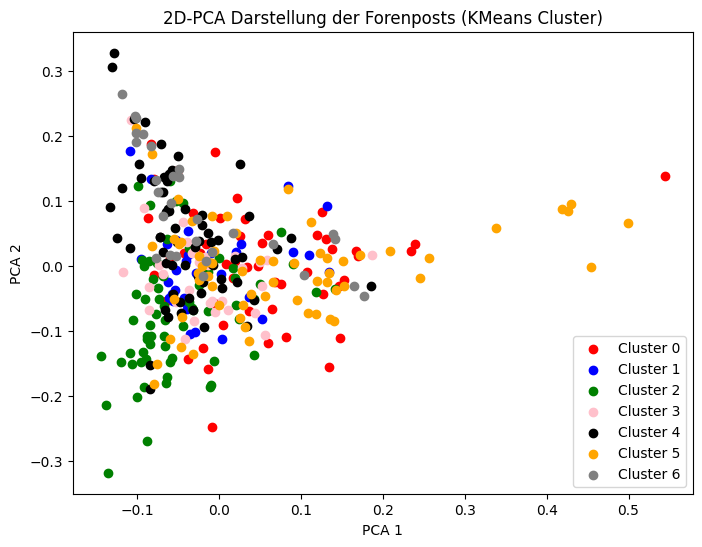

In [175]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA zur 2D-Visualisierung
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(result.toarray())

# Cluster-Farben
colors = ['red', 'blue', 'green', 'pink', 'black', 'orange', 'grey'] #, 'black', 'orange', 'grey'

plt.figure(figsize=(8, 6))
for i in range(k):
    points = tfidf_2d[labels == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], label=f"Cluster {i}")

plt.title("2D-PCA Darstellung der Forenposts (KMeans Cluster)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


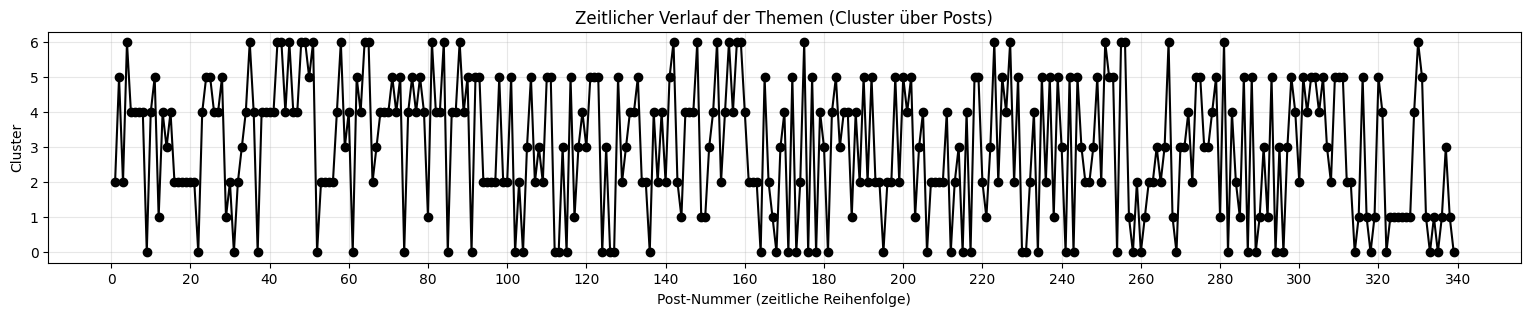

In [170]:
import matplotlib.ticker as ticker

plt.figure(figsize=(19, 3))
plt.plot(range(1, len(labels)+1), labels, marker='o', linestyle='-', color='black')

# Maximal 20 Ticks auf der X-Achse
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

plt.yticks(sorted(set(labels)))
plt.xlabel("Post-Nummer (zeitliche Reihenfolge)")
plt.ylabel("Cluster")
plt.title("Zeitlicher Verlauf der Themen (Cluster über Posts)")

plt.grid(True, alpha=0.3)
plt.show()


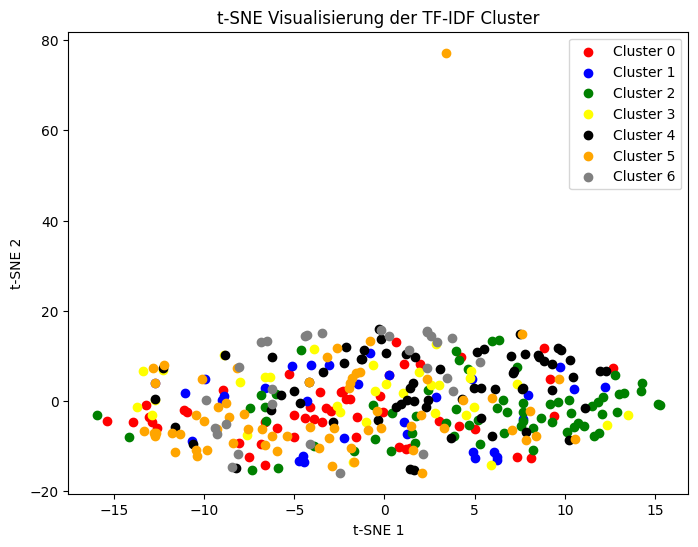

In [157]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# t-SNE erzeugen (2 Dimensionen)
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
tfidf_tsne = tsne.fit_transform(result.toarray())

# Plot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', "yellow", 'black', 'orange', 'grey']

for i in range(k):
    pts = tfidf_tsne[labels == i]
    plt.scatter(pts[:, 0], pts[:, 1], c=colors[i], label=f"Cluster {i}")

plt.title("t-SNE Visualisierung der TF-IDF Cluster")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()


/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


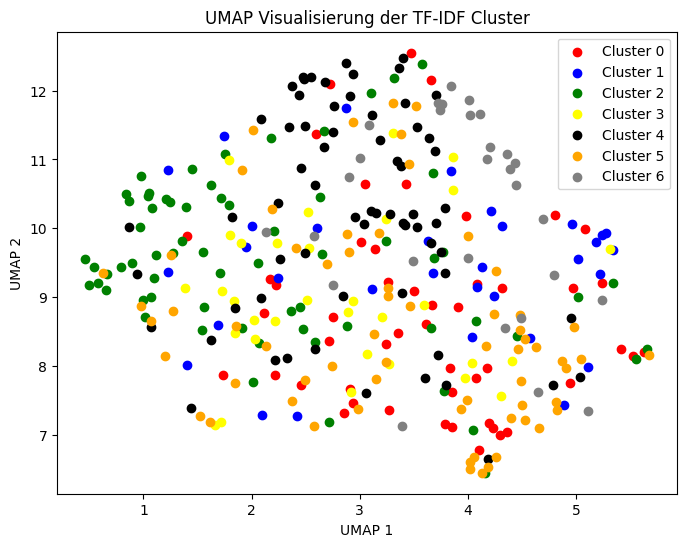

In [158]:
import umap
import matplotlib.pyplot as plt

# UMAP erzeugen
umap_model = umap.UMAP(n_components=2, random_state=42)
tfidf_umap = umap_model.fit_transform(result.toarray())

# Plot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'yellow', 'black', 'orange', 'grey']

for i in range(k):
    pts = tfidf_umap[labels == i]
    plt.scatter(pts[:, 0], pts[:, 1], c=colors[i], label=f"Cluster {i}")

plt.title("UMAP Visualisierung der TF-IDF Cluster")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


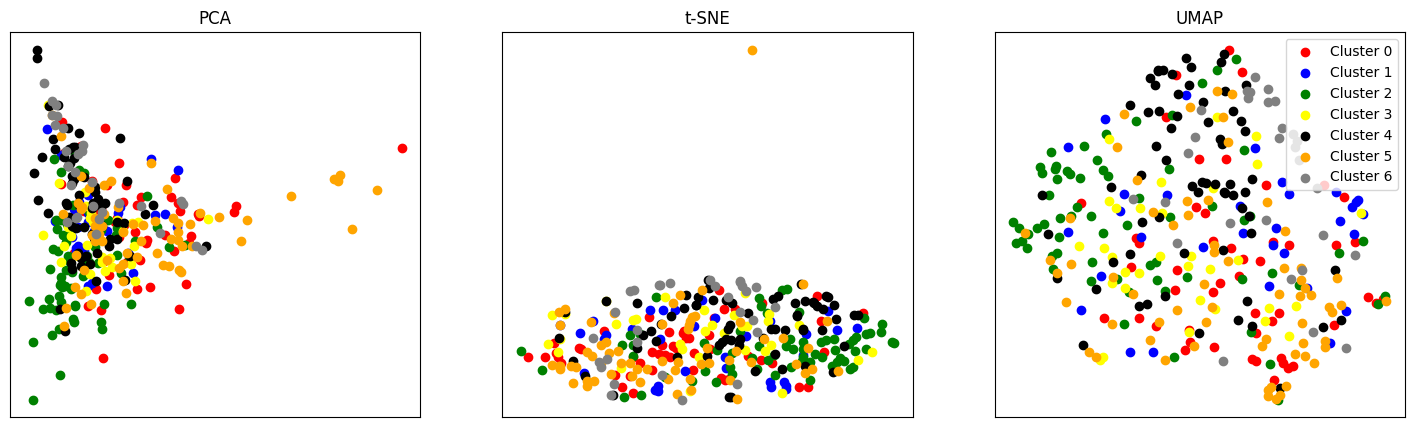

In [173]:
# PCA zur 2D-Visualisierung
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(result.toarray())

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

methods = {
    "PCA": tfidf_2d,
    "t-SNE": tfidf_tsne,
    "UMAP": tfidf_umap
}

for ax, (name, emb) in zip(axs, methods.items()):
    for i in range(k):
        pts = emb[labels == i]
        ax.scatter(pts[:, 0], pts[:, 1], c=colors[i], label=f"Cluster {i}")
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.legend()
plt.show()


/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


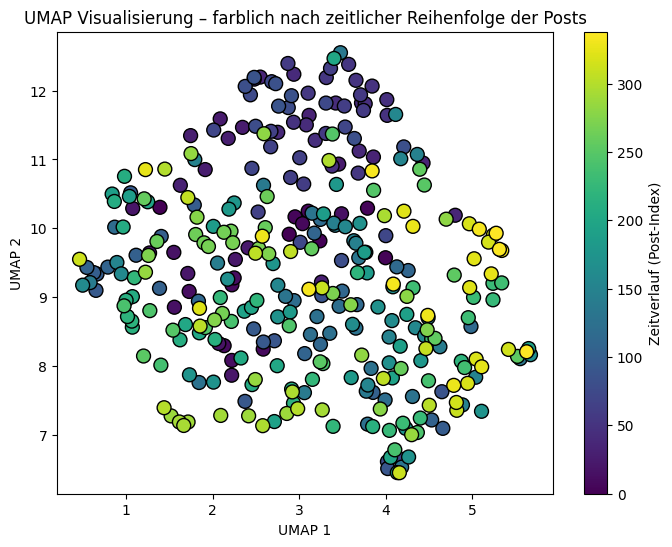

In [160]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# UMAP berechnen (2D)
umap_model = umap.UMAP(n_components=2, random_state=42)
tfidf_umap = umap_model.fit_transform(result.toarray())

# Zeitindex = einfach die Reihenfolge 0,1,2,... der Dokumente
time_index = np.arange(len(posts))

plt.figure(figsize=(8, 6))

# Scatterplot: Farbe = Zeitverlauf
scatter = plt.scatter(
    tfidf_umap[:, 0],
    tfidf_umap[:, 1],
    c=time_index,
    cmap="viridis",
    s=100,
    edgecolors='black'
)

plt.colorbar(scatter, label="Zeitverlauf (Post-Index)")
plt.title("UMAP Visualisierung – farblich nach zeitlicher Reihenfolge der Posts")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.show()


In [166]:
import umap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# ----------------------------
#  1. UMAP berechnen
# ----------------------------
umap_model = umap.UMAP(n_components=2, random_state=42)
tfidf_umap = umap_model.fit_transform(result.toarray())

# Zeitindex = Reihenfolge der Posts
time_index = np.arange(len(posts))

# ----------------------------
#  2. Animation vorbereiten
# ----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Hintergrundpunkte anzeigen
ax.scatter(tfidf_umap[:, 0], tfidf_umap[:, 1], c='lightgray', s=50)

# Animierter Scatterplot (startet leer)
scatter = ax.scatter(
    [], [],
    c=[],                     # Farben werden dynamisch gesetzt
    cmap="viridis",
    s=120,
    edgecolors="black",
    vmin=time_index.min(),
    vmax=time_index.max()
)

ax.set_title("UMAP – Animierter zeitlicher Verlauf der Forenposts")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# ----------------------------
#  3. Update-Funktion
# ----------------------------
def update(frame):
    # Werte bis zum aktuellen Frame anzeigen
    current_x = tfidf_umap[:frame+1, 0]
    current_y = tfidf_umap[:frame+1, 1]

    scatter.set_offsets(np.c_[current_x, current_y])
    scatter.set_array(time_index[:frame+1])  # Farben nach Zeitverlauf

    return scatter,

# ----------------------------
#  4. Animation erzeugen
# ----------------------------
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(posts),
    interval=800,
    repeat=False
)

# ----------------------------
#  5. Export als GIF
# ----------------------------
ani.save(
    "umap_timeline.gif",
    writer="imagemagick",
    dpi=120
)

# ----------------------------
#  6. Export als MP4
# ----------------------------
ani.save(
    "umap_timeline.mp4",
    writer="ffmpeg",
    fps=1   # 1 Frame pro Sekunde → 800ms wie Animation
)

plt.close(fig)   # Fenster schließen nach Export

print("GIF und MP4 erfolgreich gespeichert!")


/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
2025-11-27 21:23:39,810 - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-11-27 21:23:39,811 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2025-11-27 21:23:56,655 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-11-27 21:23:56,656 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x600 -pix_fmt rg

GIF und MP4 erfolgreich gespeichert!


_________________________

# tf-idf auf pos-tags

In [2]:
import spacy
from spacy_layout import spaCyLayout
from pipeline_merge_pdf import process_pdf_folder
import os
import time

#Ordner, in dem PDFs liegen
pdf_folder = "../data/DSA/Der_blaue_Bruder"
#pdf_folder = "../data/DSA/Die_Stadt_des_Feuers"
merged_pdf_path = os.path.join(pdf_folder, "_combined.pdf")

#Prüfen ob eine merged-Datei bereits vorhanden ist. Falls nicht, diese erzeugen
if os.path.exists(merged_pdf_path):
    print("Die Datei _combined.pdf existiert bereits unter folgendem Pfad:",merged_pdf_path)
    print("Lade die Datei lokal..\n")
    time.sleep(0.5)
    nlp = spacy.blank("de")
    layout = spaCyLayout(nlp)
    doc = layout(merged_pdf_path)
else:
    print("Die Datei _combined.pdf existiert noch nicht. Merge-Pipeline wird durchgeführt..")
    time.sleep(0.5)
    #Pipeline ausführen
    doc = process_pdf_folder(pdf_folder)

#spaCy-Doc
print("\nAnzahl Layout-Spans:", len(doc.spans["layout"]))

Die Datei _combined.pdf existiert bereits unter folgendem Pfad: ../data/DSA/Der_blaue_Bruder/_combined.pdf
Lade die Datei lokal..



2025-11-28 13:14:49,614 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-28 13:14:49,632 - INFO - Going to convert document batch...
2025-11-28 13:14:49,633 - INFO - Initializing pipeline for StandardPdfPipeline with options hash f9730ffaa6e7f8d4fb0c98c8df3f18cb
2025-11-28 13:14:49,634 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2025-11-28 13:14:49,636 - INFO - easyocr cannot be used because it is not installed.
2025-11-28 13:14:49,638 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-11-28 13:14:49,650 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-11-28 13:14:49,656 [RapidOCR] download_file.py:60: File exists and is valid: /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-11-28 13:14:49,656 [RapidOCR] torch.py:54: Using /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO


Anzahl Layout-Spans: 1833


In [3]:
from pipeline_preproc_pdf import process_doc_into_posts

#Posts extrahieren + bereinigen
posts = process_doc_into_posts(doc)

#Posts ausgeben
for i, p in enumerate(posts):
    print(f"--- Post {i+1} ---\n{p}\n")

--- Post 1 ---
Die Grafschaft Heldentrutz zwischen Finsterkamm und Finsterbach ist eine der ärmsten und wildesten Regionen Weidens. Sie wird von zahlreichen dichten und gefährlichen Wäldern, mit Harpyien, Orks und Drachen, urwüchsigen Wiesen sowie von Heide- und Moorlandschaften geprägt. Neben ein wenig Kornwirtschaft betreiben die Leute vor allem Kohl- und Rübenanbau, sowie Viehwirtschaft, vor allem Schafe und Ziegen. Einzige  Ausnahme  in der ganzen Ärmlichkeit ist die Baronie Nordhag mit der gleichnamigen Stadt, die durch die dort vorhandenen Salzvorkommen zu Reichtum gekommen  ist.  Nordhag bildet das wirtschaftliche und kulturelle Zentrum der Grafschaft, liegt an wichtigen Handelswegen (Norrnstieg, Alter Weg,  Alte Straße), richtet zweimal  im Jahr den großen Wollmarkt aus und ist durch die Feste Norrbrug ganz gut geschützt. Am 10. Efferd des Jahres 1040 BF, zur Zeit des zweiten Wollmarktes leben in Nordhag um  die 900 Einwohner, man  findet dort Tempel  von Rondra, Phex, Peraine 

In [4]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("de_core_news_lg")

reise_patterns = [
    # wanderte, wanderten, wanderst, wandert, etc.
    [{"LOWER": {"REGEX": "^wander"} , "POS": "VERB"}],

    # Lemma: reisen, ziehen, marschieren, durchqueren
    [{"LEMMA": {"IN": ["erreichen","reisen","ziehen","marschieren","durchqueren"]}, "POS": "VERB"}],

    # trennbares aufbrechen → brach ... auf
    [{"LEMMA": "brechen", "POS": "VERB"}, {"LOWER": "auf"}],

    # Nomen
    [{"LEMMA": {"IN": ["reise","weg","pfad","expedition","marsch"]}, "POS": "NOUN"}],
]

kampf_patterns = [
    [{"LEMMA": {"IN": ["kämpfen","angreifen","verteidigen","zuschlagen","stechen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["kampf","angriff","duell","schlacht","gegner","feind"]}, "POS": "NOUN"}]
]

ausruhen_patterns = [
    # ruhten
    [{"LEMMA": {"IN": ["ruhen","rasten","schlafen","lagern","entspannen"]}, "POS": "VERB"}],
    
    # ruhten ... aus  (trennbar!)
    [{"LEMMA": "ruhen"}, {"LOWER": "aus"}],

    # Nomen
    [{"LEMMA": {"IN": ["rast","pause","lager","ruhe","erholung"]}, "POS": "NOUN"}]
]

rettung_patterns = [
    [{"LEMMA": {"IN": ["retten","befreien","beschützen","opfern"]}, "POS": "VERB"}],
    [{"LOWER": {"IN": ["rettung","hilferuf","opfer","heldentat","gefahr","bedrohung"]}, "POS": "NOUN"}]
]

flucht_patterns = [
    # fliehen, entkommen, flüchten
    [{"LEMMA": {"IN": ["fliehen","entkommen","flüchten","verstecken"]}, "POS": "VERB"}],

    # trennbares wegrennen / rannte ... weg
    [{"LEMMA": "rennen", "POS": "VERB"}, {"LOWER": "weg"}],
    [{"LOWER": "weg"}, {"LEMMA": "rennen"}],

    [{"LEMMA": {"IN": ["flucht","unterschlupf","versteck","panik"]}, "POS": "NOUN"}]
]

training_patterns = [
    [{"LEMMA": {"IN": ["trainieren","üben","vorbereiten","meditieren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["training","übung","vorbereitung","lektion","technik"]}, "POS": "NOUN"}]
]

verfolgung_patterns = [
    [{"LEMMA": {"IN": ["verfolgen","jagen","suchen"]}, "POS": "VERB"}],
    [{"LEMMA": "spüren", "POS": "VERB"}, {"LOWER": "auf"}],
    [{"LEMMA": {"IN": ["verfolgung","jagd","spur","fährte"]}, "POS": "NOUN"}]
]

ruf_patterns = [
    [{"LEMMA": {"IN": ["rufen","einladen","beauftragen","verkünden","offenbaren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["ruf","auftrag","prophezeiung","vision","botschaft"]}, "POS": "NOUN"}]
]
belohnung_patterns = [
    [{"LEMMA": {"IN": ["belohnen","erkennen","verstehen","entdecken","gewinnen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["belohnung","schatz","erkenntnis","wahrheit","einsicht"]}, "POS": "NOUN"}]
]

categories = {
    "Reise": reise_patterns,
    "Kampf": kampf_patterns,
    "Ausruhen": ausruhen_patterns,
    "Rettung": rettung_patterns,
    "Flucht": flucht_patterns,
    "Training": training_patterns,
    "Verfolgung": verfolgung_patterns,
    "Ruf": ruf_patterns,
    "Belohnung": belohnung_patterns
}

# Matcher erstellen
matcher = Matcher(nlp.vocab)

# Patterns dem Matcher hinzufügen
for label, patterns in categories.items():
    matcher.add(label, patterns)

for post in posts:
    doc = nlp(post)
    matches = matcher(doc)
    #print(matches)

    # Ergebniscontainer
    category_hits = {c: [] for c in categories}

    # Treffer zuordnen
    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        category_hits[label].append(span.text)

    # Ausgabe
    for cat, hits in category_hits.items():
        if hits:
            print(f"{cat}: {hits}")


Reise: ['ziehen', 'erreichte']
Verfolgung: ['verfolgte']
Verfolgung: ['suchen', 'sucht']
Belohnung: ['verstehen', 'erkennen']
Verfolgung: ['suchte']
Reise: ['erreicht']
Reise: ['erreichen']
Reise: ['gereist']
Reise: ['reisen']
Ausruhen: ['entspannt']
Ruf: ['ruft']
Verfolgung: ['suchen']
Belohnung: ['versteht']
Belohnung: ['verstehen']
Belohnung: ['verstehen']
Reise: ['reise']
Ausruhen: ['ruht']
Belohnung: ['versteht']
Verfolgung: ['suche']
Verfolgung: ['sucht']
Reise: ['zieht']
Belohnung: ['versteht']
Reise: ['gereist']
Reise: ['gereist']
Flucht: ['verstecken']
Reise: ['zieht']
Verfolgung: ['suche']
Rettung: ['Opfer']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Reise: ['zieht']
Verfolgung: ['sucht']
Belohnung: ['verstehen']
Belohnung: ['verstehe']
Reise: ['zieht', 'erreicht']
Reise: ['erreichen', 'erreichen']
Rettung: ['befreien']
Verfolgung: ['suchen']
Verfolgung: ['sucht']
Training: ['vorbereiten']
Belohnung: ['ve

In [5]:
for post in posts:
    doc = nlp(post)
    matches = matcher(doc)

    hits = []

    # Alle Treffer extrahieren
    for match_id, start, end in matches:
        span = doc[start:end]
        hits.append(span.text)

    # Ausgabe nur der Treffer
    if hits:
        print(hits)


['ziehen', 'verfolgte', 'erreichte']
['verstehen', 'erkennen', 'suchen', 'sucht']
['suchte']
['erreicht']
['erreichen']
['gereist']
['entspannt', 'reisen']
['ruft']
['versteht', 'suchen']
['verstehen']
['verstehen']
['reise']
['ruht']
['versteht']
['suche']
['sucht']
['versteht', 'zieht']
['gereist']
['verstecken', 'gereist']
['zieht']
['suche']
['Opfer']
['suchen']
['suchen']
['suchen']
['suchen']
['suchen']
['zieht']
['sucht']
['verstehen']
['verstehe']
['zieht', 'erreicht']
['befreien', 'erreichen', 'suchen', 'erreichen']
['sucht']
['vorbereiten']
['verstanden']
['verstehe']
['erreichte']
['suchen']
['erkennt']
['entdeckt', 'erkennen', 'erkennen']
['fliehen']
['zieht', 'erkennen', 'reist']
['erkennt']
['entdecken']
['suchen']
['suchen']
['entdeckt', 'erkannt', 'suchen', 'sucht', 'erkennen']
['vorbereitet', 'ziehen']
['erkennen', 'verkündet']
['entdecken']
['ziehen']
['entdeckt']
['gewonnen']
['verstand', 'erkennen']
['sucht']
['ziehen']
['suchen', 'zieht', 'erkennen']
['sucht']
['zi

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

german_stopwords = stopwords.words('german') #Stopwords aus NLTK laden

newwords = ["ja", "wurde", "wäre", "setzt", "mal", "habt", "12", "10", "100", "1000", "11", "00", "02", "053", "1012", "14", "15", "16", "20", "200"]
german_stopwords.extend(newwords)

print(german_stopwords)

tfidf = TfidfVectorizer(stop_words=german_stopwords, max_df=0.95, min_df=1)
result = tfidf.fit_transform(hits)

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anderr', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies', 'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euc

[nltk_data] Downloading package stopwords to /home/timc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
import pandas as pd

words = tfidf.get_feature_names_out()
df = pd.DataFrame(result.toarray(), columns=words)
print(df)